In [1]:
# import statements

import numpy as np
import numpy.random as ra
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
# Set N = side-length, F = number of frames, I = iterations per frame, L = last completed frame, and S = update density
N = 128
F = 3000
I = 200
L = 2280
S = 0.05

In [5]:
# Define auxiliary functions (fast)

theta = None

def InsideHexagon(i,j):
    return i >= 0 and i < 2*N-1 and j >= 0 and j < 2*N-1 and i > j-N and j > i-N

def HexBC(i,j):
    if InsideHexagon(i,j):
        return theta[i,j]
    elif i >= j and i < N-1:
        return (0/6)*2*np.pi
    elif i >= N-1 and j < N-1:
        return (1/6)*2*np.pi
    elif j >= N-1 and i > j:
        return (2/6)*2*np.pi
    elif i <= j and i > N-1:
        return (3/6)*2*np.pi
    elif i <= N-1 and j > N-1:
        return (4/6)*2*np.pi
    elif j <= N-1 and i < j:
        return (5/6)*2*np.pi

adjacency = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(-1,-1)]

def Hloc(i,j,proptheta=None):
    if proptheta is None:
        proptheta = HexBC(i,j)
    return - sum([np.cos(proptheta - HexBC(i+a,j+b)) for (a,b) in adjacency])

def MetropolisUpdate(i,j,beta=1.1343):
    proptheta = ra.uniform(0,2*np.pi)
    if ra.uniform(0,1) < np.exp(- beta * (Hloc(i,j,proptheta) - Hloc(i,j))):
        theta[i,j] = proptheta


beta = lambda x : 1 + 15 * (1+100*x**6) * (x-1/3)**3

In [6]:
# Run simulation (slow)

if L > -1:
    theta = np.load(f'hexdata/{L:06d}.npy').reshape((2*N-1,2*N-1))
else:
    theta = ra.uniform(0,2*np.pi,size=(2*N-1,2*N-1))
    for i in range(2*N-1):
        for j in range(2*N-1):
            theta[i,j] = HexBC(i,j)

for frame in tqdm(range(L+1, F)):
    b = beta(frame/F)

    for _ in range(I):
        to_update = ra.uniform(0,1,size=(2*N-1,2*N-1)) < 0.05

        for i in range(2*N-1):
            for j in range(2*N-1):
                if InsideHexagon(i,j) and to_update[i,j]:
                    MetropolisUpdate(i,j,beta=b)

    np.save(f'hexdata/{frame:06d}.npy',theta)

100%|██████████| 719/719 [1:31:03<00:00,  7.60s/it]


In [7]:
# Generate images for video (slow)

thetas = [np.load(f'hexdata/{i:06d}.npy').reshape((2*N-1,2*N-1)) for i in range(L+1,F)]

for frame in tqdm(range(L+1,F)):
    plt.imsave(f'heximages/{frame:06d}.png', thetas[frame-L-1], format='png', cmap='hsv', vmin=0, vmax=2*np.pi)

100%|██████████| 719/719 [00:14<00:00, 50.95it/s]


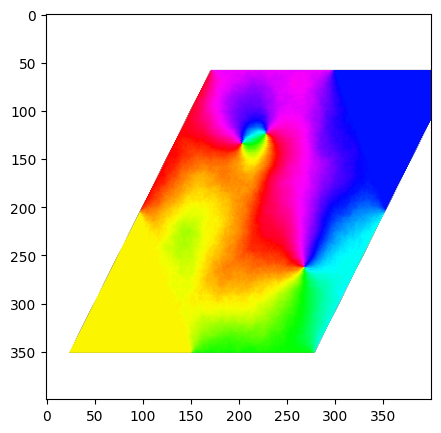

In [8]:
# Hexagon rendering

AxialToCartesian = np.array([[1, 1/2,-200],
                            [0,np.sqrt(3)/2,-50],
                            [0,0,1]])

img = Image.open(f'heximages/002999.png')
transformed = img.transform((400,400), Image.AFFINE, data=AxialToCartesian.flatten()[:6], resample=Image.NEAREST)
plt.figure(figsize=(5,5))
plt.imshow(np.asarray(transformed))